In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U scikit-fuzzy

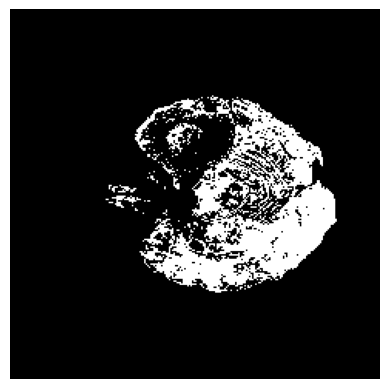

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Define kernel function (Gaussian kernel)
def gaussian_kernel(x1, x2, sigma=70):
    return np.exp(-np.sum((x1 - x2)**2) / (2 * (sigma**2)))

# Initialize cluster centers using k-means++
def initialize_centers(data_points, n_clusters):
    centers = np.zeros((n_clusters, data_points.shape[1]))
    # Initialize the first center randomly
    centers[0] = data_points[np.random.randint(0, len(data_points))]
    for i in range(1, n_clusters):
        # Compute distances from each data point to the nearest center
        distances = np.array([min([np.linalg.norm(point - center) for center in centers[:i]]) for point in data_points])
        # Choose the data point with the maximum distance as the next center
        centers[i] = data_points[np.argmax(distances)]
    return centers

# Fuzzy C-Means clustering
def fuzzy_c_means(data_points, n_clusters, max_iterations=1, tolerance=1e-4, m=2, alpha=15, lambda_val=15, kernel_function=gaussian_kernel):
    # Initialize cluster centers using k-means++
    centers = initialize_centers(data_points, n_clusters)

    # Initialize membership matrix randomly
    membership_matrix = np.random.rand(n_clusters, len(data_points))

    for _ in range(max_iterations):
        # Compute distance matrix
        distance_matrix = np.zeros((n_clusters, len(data_points)))
        for j in range(n_clusters):
            for i in range(len(data_points)):
                distance_matrix[j, i] = kernel_function(data_points[i], centers[j])

        # Update membership matrix
        prev_membership_matrix = np.copy(membership_matrix)
        for j in range(n_clusters):
            for i in range(len(data_points)):
                numerator = np.exp((-lambda_val + 2 * (1 + alpha) * (1 - distance_matrix[j, i])) * (alpha * np.sum(distance_matrix[:, i] * membership_matrix[:, j]) - membership_matrix[j, i]))
                denominator = np.sum([np.exp((-lambda_val + 2 * (1 + alpha) * (1 - distance_matrix[k, i])) * (alpha * np.sum(distance_matrix[:, i] * membership_matrix[:, k]) - membership_matrix[k, i])) for k in range(n_clusters)])
                membership_matrix[j, i] = numerator / denominator

        # Update cluster centers
        prev_centers = np.copy(centers)
        for j in range(n_clusters):
            numerator = np.sum([(membership_matrix[j, i] * kernel_function(data_points[i], centers[j]) * data_points[i]) + (alpha * (membership_matrix[j, i] - distance_matrix[j, i]) ** 2 * data_points[i]) for i in range(len(data_points))], axis=0)
            denominator = np.sum([membership_matrix[j, i] * kernel_function(data_points[i], centers[j]) + (alpha * (membership_matrix[j, i] - distance_matrix[j, i]) ** 2) for i in range(len(data_points))])
            centers[j] = numerator / denominator

        # Check for convergence
        center_change = np.linalg.norm(centers - prev_centers)
        membership_change = np.linalg.norm(membership_matrix - prev_membership_matrix)
        if center_change < tolerance and membership_change < tolerance:
            break

    return centers, membership_matrix
# Define the path to your NIfTI image
image_path =  '/content/drive/MyDrive/BraTS20_Training_001_flair.nii'


# Load the NIfTI image
image_data = nib.load(image_path).get_fdata()

# Extract a slice of the NIfTI image (slice 50)
slice_image = image_data[:, :, 50]



# Reshape the image into a 1D array of data points
data_points = slice_image.reshape((-1, 1)).astype(np.float32)

# Define parameters
n_clusters = 2
max_iterations = 10
tolerance = 1e-4
m = 2
alpha = 10
lambda_val = 10

# Perform Fuzzy C-Means clustering
centers, membership_matrix = fuzzy_c_means(data_points, n_clusters, max_iterations, tolerance, m, alpha, lambda_val)

# Extract cluster labels
cluster_labels = np.argmax(membership_matrix, axis=0)

# Reshape the cluster labels back to the shape of the original image
clustered_image = cluster_labels.reshape(slice_image.shape)

# Display the clustered image
plt.imshow(clustered_image, cmap='gray')
plt.axis('off')
plt.show()


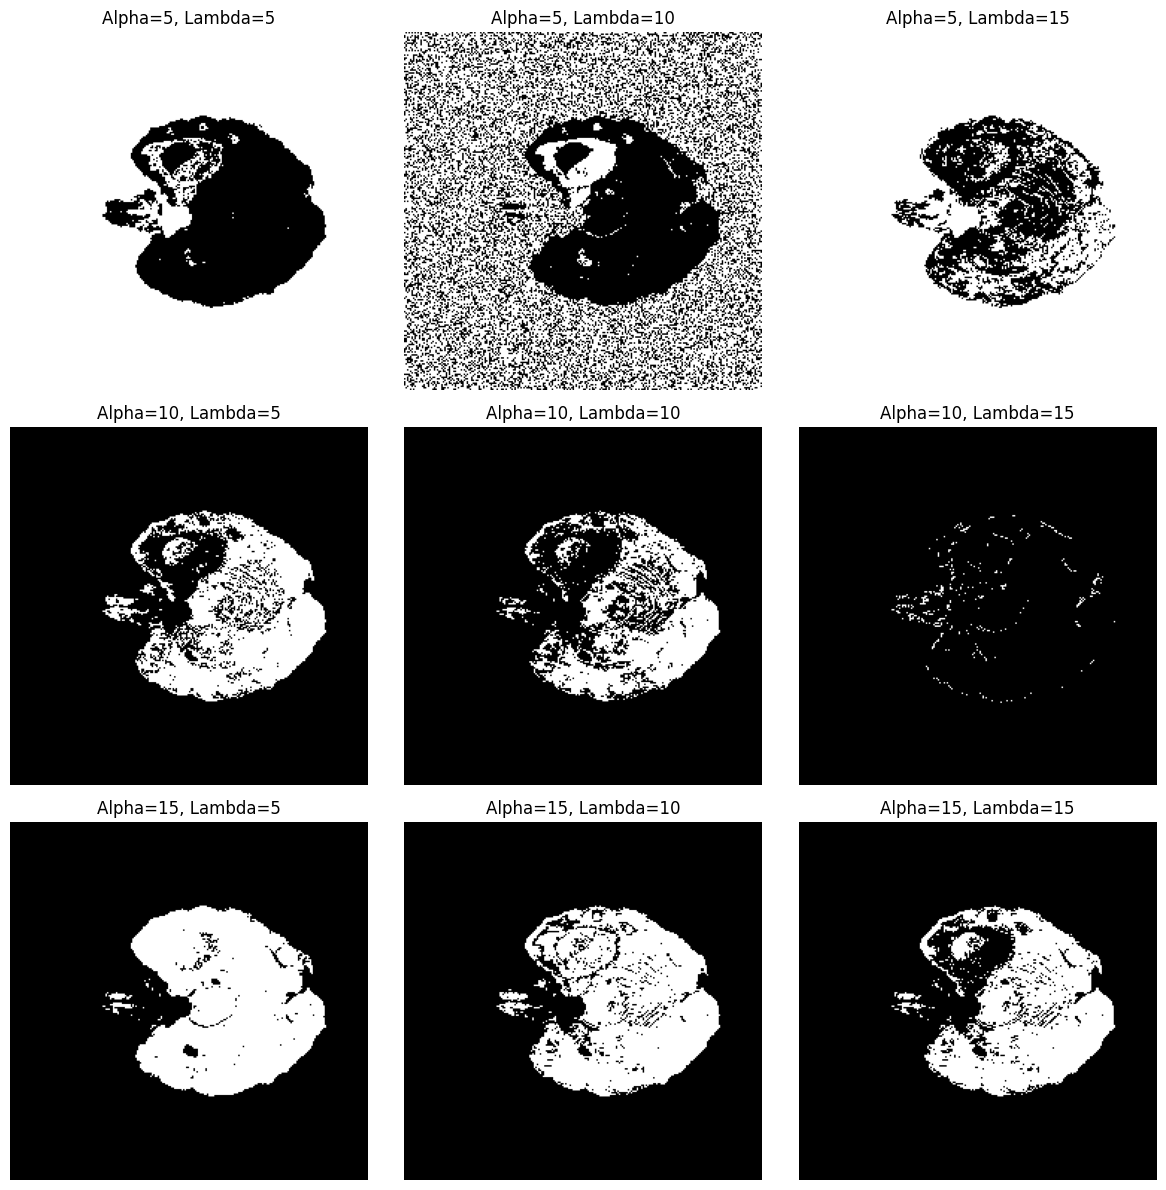

In [ ]:
# Reshape the image into a 1D array of data points
data_points = slice_image.reshape((-1, 1)).astype(np.float32)

# Define the range of parameter values to test
alpha_values = [5, 10, 15]
lambda_values = [5, 10, 15]

# Create subplots to display the clustered images for different parameter values
fig, axes = plt.subplots(len(alpha_values), len(lambda_values), figsize=(12, 12))

for i, alpha in enumerate(alpha_values):
    for j, lambda_val in enumerate(lambda_values):
        # Perform Fuzzy C-Means clustering
        centers, membership_matrix = fuzzy_c_means(data_points, n_clusters=2, max_iterations=10, alpha=alpha, lambda_val=lambda_val)

        # Extract cluster labels
        cluster_labels = np.argmax(membership_matrix, axis=0)

        # Reshape the cluster labels back to the shape of the original image
        clustered_image = cluster_labels.reshape(slice_image.shape)

        # Display the clustered image
        axes[i, j].imshow(clustered_image, cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Alpha={alpha}, Lambda={lambda_val}')

plt.tight_layout()
plt.show()